# sprint11課題 深層学習スクラッチディープニューラルネットワーク

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていきます。  
その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。  

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。  

## 新たなニューラルネットワーク分類器のクラスを作成する  
Sprint9で作成したものとは別に、ニューラルネットワーク分類器のクラス*ScratchDeepNeuralNetrowkClassifier*を作成してください。  
## 層などのクラス化 
**コーディング**  
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。  

**手を加える箇所**

- 層の数
- 層の種類（今後は畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法  

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

# 【問題1】全結合層のクラス化
**コーディング**

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。  

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。  

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。  

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。  

初期化方法と最適化手法のクラスについては後述します。

### インポートと以前までのスプリントのクラスを呼び込む。

In [1]:
from tqdm import tqdm_notebook as tqdm
import pyprind
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Using TensorFlow backend.


In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    """
    def __init__(self, X, y, batch_size = 10):
        self.batch_size = batch_size
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

## クラス作成

In [3]:
class FC:
    """
    ノード数pre_nodesからnodesへの全結合層
    Parameters
    ----------
    nodes : int
      層のノード数
    
    Attributes
    ----------
    group : 'FC'
      layerの種類
    """
    def __init__(self, nodes):
        self.nodes = nodes
        self.group = 'FC'
        
    def initialize(self, pre_nodes, summary, init_type, optimizer, sigma=1e-2, lr=1e-2):
        """
        重み、バイアスを初期化して出力数を渡してあげる
        Parameters
        ----------
        input_dim :次の形のtuple, (入力チャンネル,高さ,横幅)
            入力サイズ
        initializer: class
            initializerのクラス
        optimizer: class
            optimizerのクラス
        lr : float(1e-2)
            optimizerに渡す学習率
        sigma : float(1e-2)
            Simpleinitializerを選んだ時のパラメータ
        """
        
        #初期値を設定する。
        initializer = Initializer(init_type, pre_nodes, sigma)
        self.W = initializer.W(pre_nodes, self.nodes)
        self.B = initializer.B(self.nodes)
        
        if summary:
            print(self.group,'layer shape={}, param={}'.format(self.W.shape,pre_nodes*self.nodes+self.nodes))

        #optimizerを設定する。
        self.optimizer = optimizer(lr)
        
        return self.nodes

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, pre_nodes)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, nodes)
            出力
        """        
        self.Z = X.copy()
        A = X @ self.W + self.B
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, pre_nodes)
            前に流す勾配
        """
        self.dB = dA
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        # 重みを更新
        self = self.optimizer.update(self)
        return dZ

# 【問題2】初期化方法のクラス化  
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。  
雛形に必要なコードを書き加えていってください。  
標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。  

In [4]:
class Initializer:
    """
    ガウス分布によるシンプルな初期値設定
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, init_type, pre_nodes, sigma):
        if init_type == 'simple':
            self.sigma = sigma
        elif init_type == 'Xavier':
            self.sigma = 1 / np.sqrt(pre_nodes)
        elif init_type == 'He':
            self.sigma = np.sqrt(2 / pre_nodes)

    def W(self,*args):
        """
        重みの初期化
        Parameters
        ----------
        args : int
          ノード数や、チャンネル数等必要なサイズを入力
        Returns
        ----------
        W :次の形のndarray, shape (args)
            重み
        """
        W = self.sigma * np.random.standard_normal(size=args)
        return W
    def B(self, *args):
        """
        バイアスの初期化
        Parameters
        ----------
        args : int
          ノード数等を入力。入力した形の必要なサイズを入力
        Returns
        ----------
        B :次の形のndarray, shape (args)
            バイアス
        """
        B = self.sigma * np.random.standard_normal(size=args)
        return B

# 【問題3】最適化手法のクラス化  
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。  
バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。  
こちらも雛形を用意しましたので、必要なコードを書き加えていってください。  
これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。  

In [5]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        layer.W -= self.lr * (layer.dW / layer.dB.shape[0])
        layer.B -= self.lr * np.mean(layer.dB, axis=0)
        return layer

# 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。  

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [6]:
class Sigmoid:
    """
    　シグモイド関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.group = 'activation'
    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列　元のshapeを保持
        """
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列  shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dA = dZ * (1 - self.Z) * self.Z
        return dA

In [7]:
class Tanh:
    """
    ハイパボリックタンジェント関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.group = 'activation'

    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列 元のshapeを保持
        """
        self.Z = np.tanh(A)
        return self.Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dA = dZ * (1 - self.Z ** 2)
        return dA

In [8]:
class Softmax:
    """
    ソフトマックス関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.entropy = None # バッチ単位でのエントロピー
        self.group = 'activation'
        
    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shape(batch_size, pre_nodes)

        Returns
        ----------
        Z : 活性化後の行列　shape(batch_size,  pre_nodes)
        """
        c = np.max(A,axis=1,keepdims=True)
        A = np.exp(A-c)
        self.Z = A / np.sum(A, axis=1, keepdims=True)
        return self.Z
    
    def backward(self, Y):
        """
        バックワードと交差エントロピーを計算
        Parameters
        ----------
        dZ : 全結合後の行列 shape(batch_size, pre_nodes)

        Returns
        ----------
        dA : 活性化後の行列　shape(batch_size,  pre_nodes)
        """
        #勾配はこっち
        dA = self.Z - Y
        return dA
    
    def loss(self, Y):
        entropy = -np.sum(Y * np.log(self.Z + 1e-5), axis=1) #サンプル毎のエントロピー(batch_size,)
        entropy = entropy.sum() / len(entropy)  # スカラー
        return entropy

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。  
ReLUは以下の数式です。
$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

x : ある特徴量。スカラー  

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。  

一方、バックプロパゲーションのための x に関する $f(x)$ の微分は以下のようになります。  
$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$  
数学的には微分可能ではないですが、 x=0 のとき 0 とすることで対応しています。   
フォワード時の x の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [9]:
class Relu:
    """
    ReLU関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.group = 'activation'
        self.mask = None

    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列　元のshapeを保持
        """
        self.mask = (A <= 0)
        Z = A.copy()
        Z[self.mask] = 0
        return  Z

    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dZ[self.mask] = 0
        
        return dZ

# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。  
しかし、一般的に良い初期値の取り方が知られています。  

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。  

XavierInitializerクラスと、HeInitializerクラスを作成します。  

それぞれの初期化方法における σ は次の式で求められます。  

### 「Xavierの初期値」  

$$
\sigma = \frac{1}{\sqrt{n}}
$$
n : 前の層のノード数  

**[論文](https://arxiv.org/pdf/1502.01852.pdf)**

### 「Heの初期値」

$$
\sigma = \sqrt{\frac{2}{n}}
$$

n : 前の層のノード数

**[論文](https://arxiv.org/pdf/1502.01852.pdf)**

### 上記2クラスともInitializerクラスに導入済み

# 【問題7】最適化手法
**コーディング**  

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。  
様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。  
まず、これまで使ってきたSGDを確認します。
$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$
α  : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）\\
\frac{∂L}{∂W_i} : W_i に関する損失 L の勾配\\
\frac{∂L}{∂B_i} : B_i に関する損失 L の勾配\\
E() : ミニバッチ方向にベクトルの平均を計算\\
$

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。  

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和H を保存しておき、その分だけ学習率を小さくします。  
学習率は重み一つひとつに対して異なることになります。  

$$ 
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$ 


$
H_i  : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）\\
H′_i : 更新した H_i\\
$

**AdaGrad**クラスを作成し、上記の数式にもとづいて実装してください。

**[論文](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)**

In [10]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H_w = 0 #最初は0
        self.H_b = 0
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        dW_mean = layer.dW / layer.dB.shape[0] #行列
        dB_mean = np.mean(layer.dB, axis=0)
        #重みの更新
        self.H_w += dW_mean * dW_mean # Hを更新
        layer.W -= self.lr * dW_mean / (np.sqrt(self.H_w) + 1e-7)
        
        self.H_b +=  dB_mean * dB_mean        
        layer.B -= self.lr * dB_mean / (np.sqrt(self.H_b) + 1e-7)
        
        return layer

# 最後は全てをまとめたクラスを実装

In [3]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    ディープなニューラルネットワーク分類器
    層を増やすことが出来る。
    バッチをランダムで抽出する。
    エポック毎にバッチを取り直すことも可能。
    
    Parameters
    ----------
    batch_size : int　(30)
        バッチサイズ
    n_epoch : int (100)
        エポック数
    e_threshold : float(1e-2)
        エポック途中終了の為のエントロピーの閾値
    n_iter : int(1000)
        1エポック辺りのイテレーション数
    repeat_batch_process : bool(True)
        Trueの場合１エポック毎にバッチをランダムに取り直す。
    restore_extraction:bool(True)
        学習するバッチをランダム抽出する際に復元か、非復元か選ぶ。基本は復元(ブートストラップ)
    seed : int(0)
        ランダムシード
        
    Attributes
    ----------
    loss : shape(n_epoch, n_iter)
        1バッチごとのエントロピー
    layers : list
        layerのリスト
    
    """

    def __init__(
        self,
        batch_size=30,
        n_epochs=100,
        e_threshold=1e-2,
        n_iter=1000,
        repeat_batch_process=True,
        restore_extraction=True,
        seed=0
    ):
        self._n_iter = n_iter
        self._repeat_batch_process = repeat_batch_process
        self._restore_extraction = restore_extraction
        self._batch_size = batch_size
        self._n_epochs = n_epochs
        self._e_threshold = e_threshold  # 誤差の閾値        
        self.loss = None
        self.epoch_loss_mean = None
                            
    def sequential(self,*layers):
        """
        layerをつなげるメソッド。
        """
        self.layers = []        
        for layer in layers:
            self.layers.append(layer)
            
    def initialize(self, input_dim, summary, init_type, optimizer, sigma=1e-2, lr=1e-2):
        """
        それぞれのlayerの初期化メソッド
        活性化層以外の層のinitializeメソッドを使う。
        """
        for layer in self.layers:
            if layer.group != 'activation':
                input_dim = layer.initialize(input_dim,summary, init_type, optimizer, sigma=sigma, lr=lr)
        

    def fit(self, X, y ,validation_split=0.1):
        """
        NNを学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, クラス)
            学習用データの正解値(one_hot_vectaされた後のもの)
        validation_split : float
            検証用データに使用する割合。        
        """
        
        # trainとvalにデータを分ける。        
        split_index = int(X.shape[0] * validation_split)
        X_train = X[split_index:]
        y_train = y[split_index:]
        X_val = X[:split_index]
        y_val = y[:split_index]
        
        # yの値をワンホットエンコーディングする。        
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_one_hot = enc.transform(y_val[:, np.newaxis])


        # repeat_batchしない場合はここでミニバッチ化
        if self._repeat_batch_process == False:
            train_batch = GetMiniBatch(X_train, y_train_one_hot,
                                       batch_size=self._batch_size) 
        # バッチをランダム取得するためのindexを取得
        batch_index = np.random.choice(int(X_train.shape[0] / self._batch_size),
                                       self._n_iter,
                                       replace=self._restore_extraction)  # n_iterのindex
        self.train_loss = []  # 1エポックの平均のlossの入れ物
        self.val_loss = []  # 1エポックの平均のlossの入れ物
        self.train_acc = []
        self.val_acc = []

        # 学習開始
        for epoch in tqdm(range(self._n_epochs)):
            if self._repeat_batch_process:
                train_batch = GetMiniBatch(
                    X_train, y_train_one_hot, batch_size=self._batch_size)  # バッチに分ける。
            for i, index in enumerate(batch_index):
                X_batch, y_batch = train_batch[index][0].copy(
                ), train_batch[index][1].copy()
                # フォワードプロパゲーション
                for layer_index in range(len(self.layers)):
                    X_batch = self.layers[layer_index].forward(X_batch)
                # バックプロパゲーション
                for layer_index in range(1, len(self.layers) + 1):
                    y_batch = self.layers[-layer_index].backward(y_batch)
            
            # エポックごとにlossとaccを計算
            tr_pred = self.predict(X_train)
            tr_loss = self.layers[-1].loss(y_train_one_hot)
            val_pred = self.predict(X_val)
            val_loss = self.layers[-1].loss(y_val_one_hot)
            tr_acc = np.sum(y_train == tr_pred) / X_train.shape[0]
            val_acc = np.sum(y_val == val_pred) / X_val.shape[0]
            self.train_loss.append(tr_loss)
            self.val_loss.append(val_loss)
            self.train_acc.append(tr_acc)
            self.val_acc.append(val_acc)
            print('{}エポック目のloss= {:.5f}'.format(epoch,tr_loss))
            # 誤差が閾値以下になったらエポック終了
            if tr_loss < self._e_threshold:
                print('lossが{:.3f}より低いよ！'.format(self._e_threshold))
                break
                
    def predict(self, X):
        """
        NNで予測する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, チャンネル数,高さ,幅)
            学習用データの特徴量        
        """

        # フォワードプロパゲーション
        out = X.copy()
        for layer in range(len(self.layers)):
            out = self.layers[layer].forward(out)

        return np.argmax(out, axis=1)

# 前回のデータセットを使用して試してみる。

In [13]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(y_train.shape) # (60000,)

(60000,)


In [14]:
dnn = ScratchDeepNeuralNetrowkClassifier(batch_size=32,
                                n_epochs=70,
                                n_iter=500,
                                repeat_batch_process=False,
                                restore_extraction=False,
                                seed=0)

In [15]:
dnn.sequential(
    FC(128),
    Relu(),
    FC(50), 
    Relu(),
    FC(10), 
    Softmax()
)

input_dim = (784)
dnn.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

FC layer shape=(784, 128), param=100480
FC layer shape=(128, 50), param=6450
FC layer shape=(50, 10), param=510


In [16]:
dnn.fit(X_train, y_train,validation_split=0.1)

0エポック目のloss= 0.22363
1エポック目のloss= 0.18141
2エポック目のloss= 0.16015
3エポック目のloss= 0.14607
4エポック目のloss= 0.13666
5エポック目のloss= 0.12939
6エポック目のloss= 0.12349
7エポック目のloss= 0.11868
8エポック目のloss= 0.11445
9エポック目のloss= 0.11111
10エポック目のloss= 0.10816
11エポック目のloss= 0.10566
12エポック目のloss= 0.10337
13エポック目のloss= 0.10156
14エポック目のloss= 0.10002
15エポック目のloss= 0.09863
16エポック目のloss= 0.09740
17エポック目のloss= 0.09639
18エポック目のloss= 0.09542
19エポック目のloss= 0.09474
20エポック目のloss= 0.09399
21エポック目のloss= 0.09340
22エポック目のloss= 0.09291
23エポック目のloss= 0.09248
24エポック目のloss= 0.09212
25エポック目のloss= 0.09179
26エポック目のloss= 0.09146
27エポック目のloss= 0.09125
28エポック目のloss= 0.09099
29エポック目のloss= 0.09078
30エポック目のloss= 0.09065
31エポック目のloss= 0.09051
32エポック目のloss= 0.09039
33エポック目のloss= 0.09032
34エポック目のloss= 0.09021
35エポック目のloss= 0.09018
36エポック目のloss= 0.09014
37エポック目のloss= 0.09011
38エポック目のloss= 0.09011
39エポック目のloss= 0.09009
40エポック目のloss= 0.09013
41エポック目のloss= 0.09016
42エポック目のloss= 0.09019
43エポック目のloss= 0.09024
44エポック目のloss= 0.09028
45エポック目のloss= 0.0903

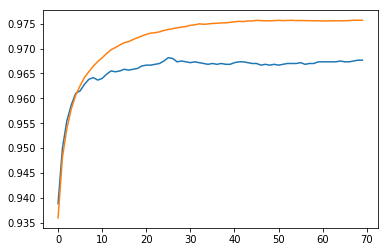

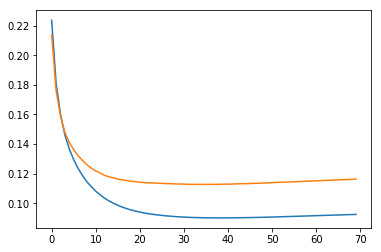

In [17]:
sns.lineplot(x=np.arange(len(dnn.train_acc)),y=dnn.val_acc)
sns.lineplot(x=np.arange(len(dnn.train_acc)),y=dnn.train_acc)
plt.show()
sns.lineplot(x=np.arange(len(dnn.train_acc)),y=dnn.train_loss)
sns.lineplot(x=np.arange(len(dnn.train_acc)),y=dnn.val_loss)

まあまあ精度が高いからとりあえずオーケー